# Essais de keras sur le dataset MNIST
## Analyse des données

In [1]:
# Imports et versions
import numpy as np
import theano
import keras
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from keras.models import Sequential
from keras.utils import np_utils
from keras.datasets import mnist
from matplotlib import pyplot as plt
from keras import backend as K

K.set_image_dim_ordering('th')

print("numpy : ", np.__version__)
print("theano : ", theano.__version__)
print("keras : ", keras.__version__)

Using Theano backend.


numpy :  1.13.3
theano :  0.9.0.dev-c697eeab84e5b8a74908da654b66ec9eca4f1291
keras :  2.0.8


In [2]:
np.random.seed(123)  # pour reproductibilité

# Chargement des données MNIST qui sont déjà mélangées
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(X_train.shape)

(60000, 28, 28)


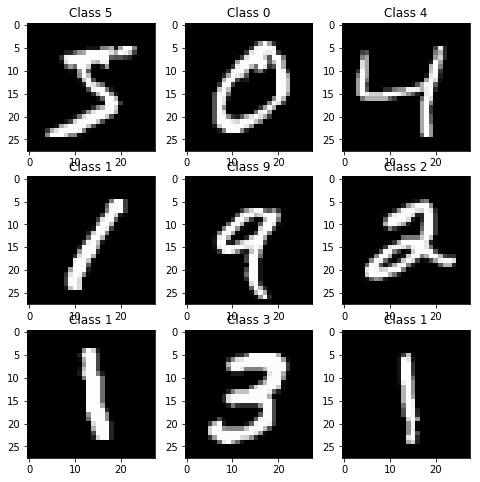

In [26]:
# Affichage de la première image
%matplotlib inline
plt.figure(figsize=(8, 8))
#plt.imshow(X_train[0])

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_train[i].squeeze(), cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[i]))

In [4]:
# Transformation de la forme des données d'entrée, il faut déclarer que les données ne sont pas (n, width, height)
# mais (n, depth, width, height) où depth est le nombre de canaux RGB. Le dataset est en n&b donc depth est 1
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
print(X_train.shape)

(60000, 1, 28, 28)


In [6]:
# Conversion en données numériques
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# normalisation des valeurs
X_train /= 255
X_test /= 255

In [7]:
# pré-traiement des classes, regardons comment elles sont représentées
print(y_train.shape)

(60000,)


In [8]:
# Problème : on devrait avoir 10 classes, une par chiffre à identifier. Au lieu de ça, on a une liste de 
# 60000 valeurs. Regardons ce que l'on y trouve
print(y_train[:10])

[5 0 4 1 9 2 1 3 1 4]


In [9]:
# Les données ne sont pas réparties dans 10 classes mais représentées dans le tableau de 60000 entrées.
# Conversion du tableau à une dimension en matrice à 10 dimensions
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)
print(Y_train.shape)

(60000, 10)


## Conception et entrainement du modèle

In [10]:
# Mise en place du modèle
# on va enchainer en séquence une série de couches
model = Sequential()

# l'input_shape correspond (1,28,28) correspond au format (depth, width, height) de nos données
# 32 représente le nombre de filtres de convolution
# 3 représente le nombre de lignes dans chaque convolution
# 3 représente le nombre de colonnes dans chaque convolution
model.add(Convolution2D(32, (3, 3), activation='relu', input_shape=(1,28,28)))
model.add(Convolution2D(32, (3, 3), activation='relu'))
# MaxPooling2D is a way to reduce the number of parameters in our model by sliding a 
# 2x2 pooling filter across the previous layer and taking the max of the 4 values in the 2x2 filter.
model.add(MaxPooling2D(pool_size=(2,2)))
# Dropout évite l'overfitting
model.add(Dropout(0.25))

# Fully connecter layer, weights from the Convolution layers must be flattened 
# (made 1-dimensional) before passing them to the fully connected Dense layer
model.add(Flatten())
# 128 représente la taille de la sortie
model.add(Dense(128, activation='relu'))
# Output layer
model.add(Dropout(0.5))
# l'output layer à une sortie de taille 10, qui correspond à nos 10 classes
model.add(Dense(10, activation='softmax'))

In [11]:
# Compilation du modèle
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [12]:
# Callbacks
# les callbacks permettent de sauvegarder les meilleurs weights 
# et de logger l'historique des métriques accuracy et loss dans un fichier
csv_logger = CSVLogger('mnist-log.csv', append=True, separator=';')
checkpoint = ModelCheckpoint('mnist-weights-best.hdf5', monitor='acc', verbose=1, save_best_only=True)
callbacks_list = [csv_logger, checkpoint]

In [13]:
# Entrainement du modèle
# validation_split permet de séparer les données en train/validation
history = model.fit(X_train, Y_train, batch_size=32, epochs=10, 
                    verbose=1, callbacks=callbacks_list, 
                    validation_split=0.05)

Train on 57000 samples, validate on 3000 samples
Epoch 1/10
57000/57000 [==============================] - 124s - loss: 1.0013 - acc: 0.6603 - val_loss: 0.2751 - val_acc: 0.9307
Epoch 2/10
57000/57000 [==============================] - 135s - loss: 0.5903 - acc: 0.8106 - val_loss: 0.2161 - val_acc: 0.9423
Epoch 3/10
57000/57000 [==============================] - 140s - loss: 0.5296 - acc: 0.8326 - val_loss: 0.1934 - val_acc: 0.9450
Epoch 4/10
57000/57000 [==============================] - 139s - loss: 0.4795 - acc: 0.8484 - val_loss: 0.1708 - val_acc: 0.9547
Epoch 5/10
57000/57000 [==============================] - 140s - loss: 0.4459 - acc: 0.8581 - val_loss: 0.1509 - val_acc: 0.9593
Epoch 6/10
57000/57000 [==============================] - 151s - loss: 0.4187 - acc: 0.8696 - val_loss: 0.1366 - val_acc: 0.9650
Epoch 7/10
57000/57000 [==============================] - 142s - loss: 0.3896 - acc: 0.8786 - val_loss: 0.1309 - val_acc: 0.9667
Epoch 8/10
57000/57000 [========================

## Evaluation du modèle

In [14]:
# Evaluation du modèle
scores = model.evaluate(X_test, Y_test, verbose=0)
#print(scores)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

CNN Error: 4.75%


In [15]:
# Historique du traitement
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

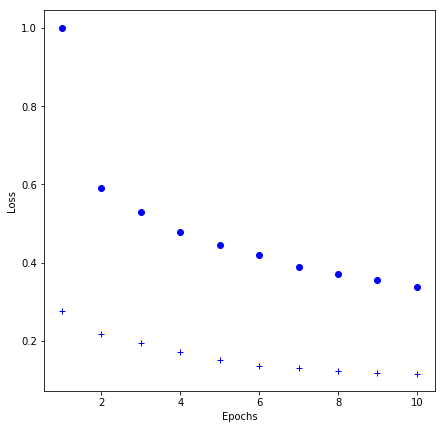

In [22]:
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

# Graphique de l'historique : affichage des pertes (loss)
plt.figure(figsize=(7, 7))
plt.plot(epochs, loss_values, 'bo')
plt.plot(epochs, val_loss_values, 'b+')
plt.xlabel('Epochs')
plt.ylabel('Loss')

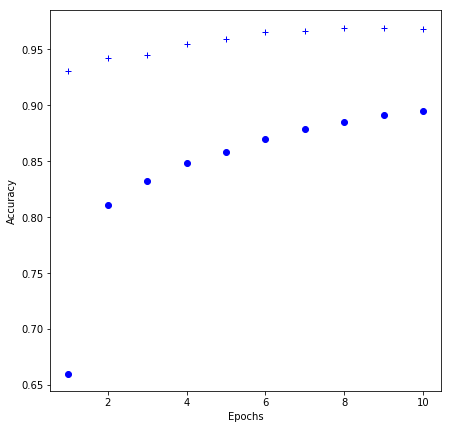

In [23]:
# Graphique de l'historique : affichage de la précision (accuracy)
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
plt.figure(figsize=(7, 7))
plt.plot(epochs, acc_values, 'bo')
plt.plot(epochs, val_acc_values, 'b+')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

In [20]:
plt.show()

## Prédictions